# Analisi di immagini

- Visualizzazione delle immagini nei canali R,G,B
- Conversione in scala di grigi
- Analisi tramite istogrammi

In [1]:
# import delle librerie
import os
import numpy as np
import matplotlib
matplotlib.use('PS')
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

from io import BytesIO
import IPython.display

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# in questa folder sono memorizzati alcuni file a supporto (path relativo al notebook corrente)
IMGSRC = 'data'
# print(f'workin dir is {os.path.abspath(".")}')

def myResourcePath(fname):
    filename = os.path.join(IMGSRC, fname)
    if not os.path.exists(filename):
        raise RuntimeError(f'file not found {filename}')
    return filename

In [2]:
# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

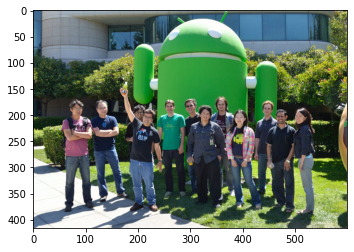

tensor type torch.FloatTensor
tensor shape torch.Size([3, 416, 600])


In [3]:
pil_image = Image.open(myResourcePath('google_android.jpg'))
rgb_image = pil2tensor(pil_image)

plot_image(rgb_image)
print(f'tensor type {rgb_image.type()}')
print(f'tensor shape {rgb_image.shape}')

In [4]:
# tensori dei singoli canali
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

r_image.shape

torch.Size([416, 600])

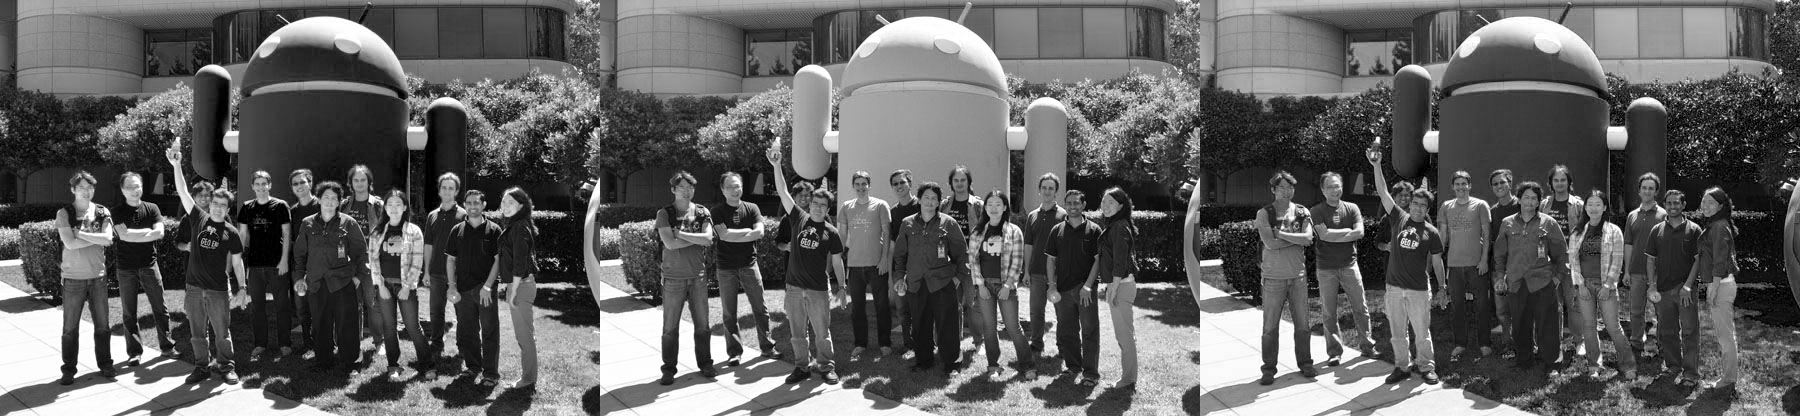

In [5]:
def show_grayscale_image(tensor):
    # IPython.display can only show images from a file.
    # So we mock up an in-memory file to show it.
    # IPython.display needs a numpy array with channels first.
    # and it also has to be uint8 with values between 0 and 255.
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy()) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Cat concatenates tensors along a given dimension, we choose width here (1), instead of height (0).
show_grayscale_image(torch.cat((r_image, g_image, b_image), 1))

Le tre immagine visualizzate sono state ottenute visualizzando un solo canale (R, G, B).

Prima osservazione: l'immagine centrale è più luminosa delle altre (notate il robottino).

Proviamo a enfetizzare il contributo del canale G

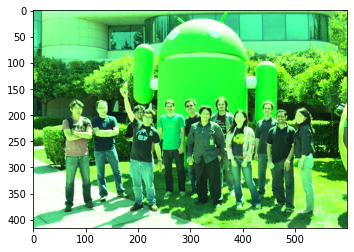

In [6]:
image_copy = rgb_image.clone()
 
# Multiply the green channel by two, clamp the values to the 0-1 range.
image_copy[1] = image_copy[1].mul(2.0).clamp(0.0, 1.0)

plot_image(image_copy)

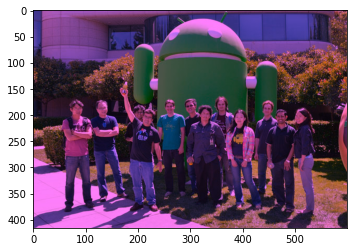

In [7]:
# Try the opposite
image_copy = rgb_image.clone()
 
# Divide the green channel by two, clamp the values to the 0-1 range.
image_copy[1] = image_copy[1].mul(0.5).clamp(0.0, 1.0)

plot_image(image_copy)

## Conversione in scala di grigi

Come possiamo convertire un'immagine RGB in scala di grigi? Un modo semplice sarebbe la media di tutti e tre i canali RGB. 

Attenzione: nel tensore i canali hanno valori compresi nell'intervallo [0,1]

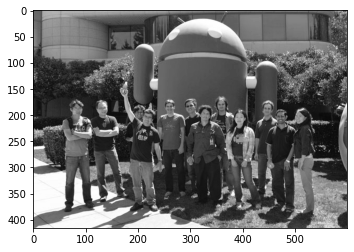

In [8]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

grayscale_image = (r_image + g_image + b_image).div(3.0)

def plot_grayscale_image(tensor):
    plt.figure()
    plt.imshow(tensor.numpy(), cmap = 'gray')
    plt.show()
    
plot_grayscale_image(grayscale_image)

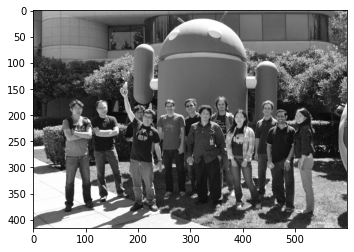

In [9]:
# weighted alternative

grayscale_image = (r_image * 0.4 + g_image * 0.5 + b_image * 0.1).clamp(0.0, 1.0)
    
plot_grayscale_image(grayscale_image)

## Luminosità

Abbiamo visto che visualizzando un solo canale posso visualizzare l'immagine in scala di grigi.  
Cambiando il contributo dei singoli canali posso variare la resa finale della conversione.

Posso fare lo stesso con i singoli canali visualizzando l'immagine nei tre canali?

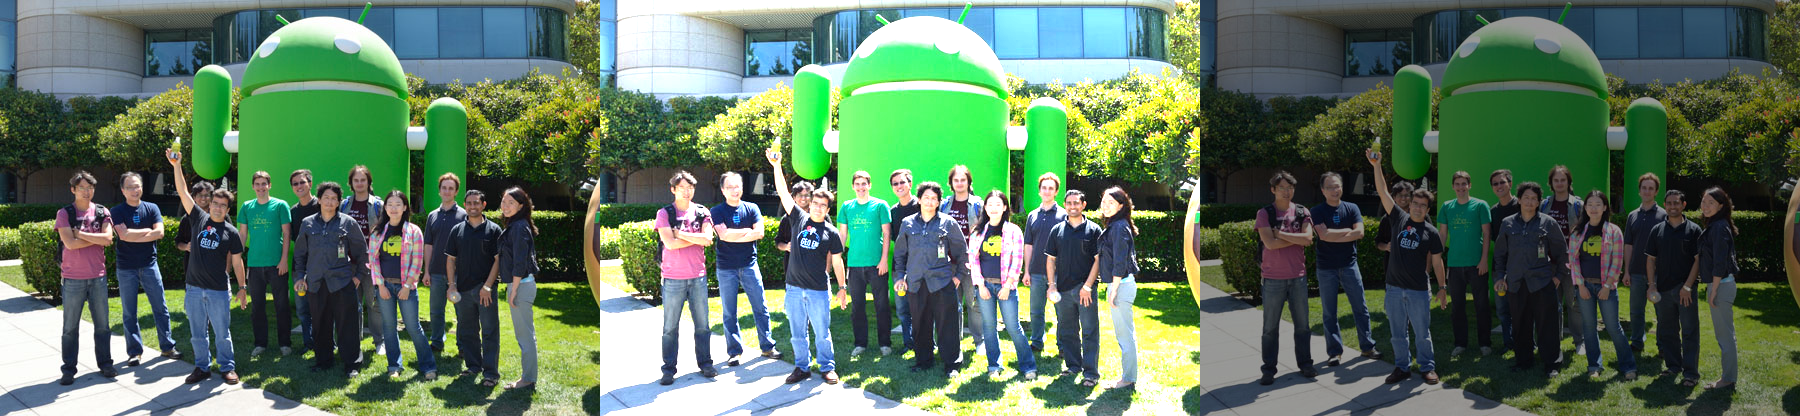

In [10]:
bright_rgb_image = rgb_image.clone()
dark_rgb_image = rgb_image.clone()

# Multiply all elements in the image by 1.8, and then clamp values between 0 and 1.
bright_rgb_image.mul_(1.8).clamp_(0, 1)

# Multiply all elements in the image by 0.6, and then clamp values between 0 and 1.
dark_rgb_image.mul_(0.6).clamp_(0, 1)

def show_image(tensor):
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy().transpose(1, 2, 0)) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Since these are color images (0: channels, 1: height, 2: width), we need to concat in the 2nd dimension. 
show_image(torch.cat((rgb_image, bright_rgb_image, dark_rgb_image), 2))

## Istogrammi
Le trasformazioni che abbiamo eseguito (moltiplicazione, divisione) hanno modificato l'immagine effettuando delle trasformazioni sui singoli canali.

Queste trasformazioni possono essere analizzate in termini di variazioni sullo spazio colore.

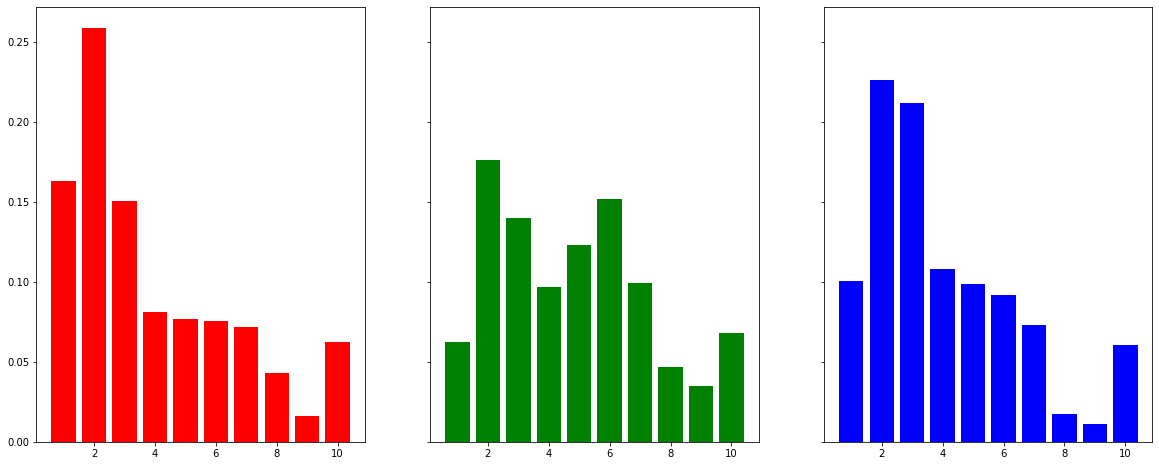

In [11]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

# Compute histograms for each channel.
hist_r = torch.histc(r_image, bins = 10, min = 0.0, max = 1.0)
hist_g = torch.histc(g_image, bins = 10, min = 0.0, max = 1.0)
hist_b = torch.histc(b_image, bins = 10, min = 0.0, max = 1.0)

# Normalize the histograms so that they sum to 1.
hist_r = hist_r.div(hist_r.sum())
hist_g = hist_g.div(hist_g.sum())
hist_b = hist_b.div(hist_b.sum())

# Plot the histograms.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(20, 8))
ax1.bar(np.linspace(1.0, 10.0, num = 10), hist_r.numpy(), color='r')
ax2.bar(np.linspace(1.0, 10.0, num = 10), hist_g.numpy(), color='g')
ax3.bar(np.linspace(1.0, 10.0, num = 10), hist_b.numpy(), color='b')

plt.show()

Valutiamo la precedente trasformazione sullo spazio colore:

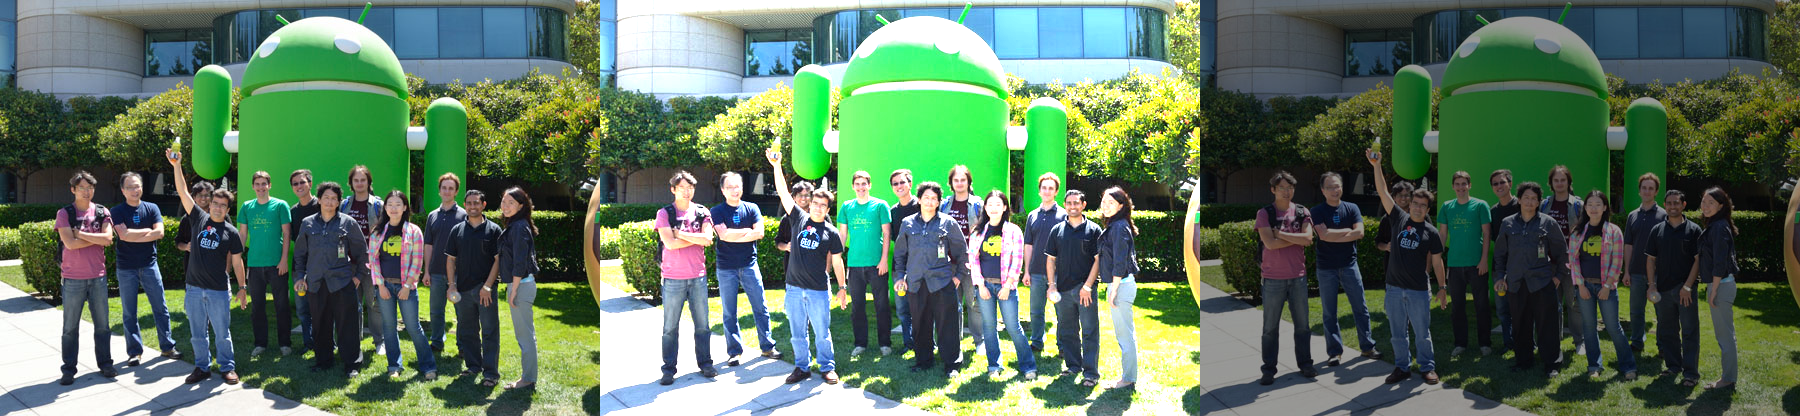

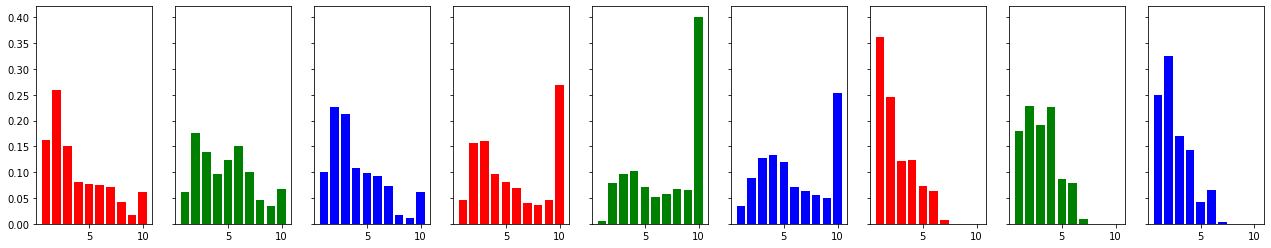

In [12]:
def get_channels(rgbim, bins=10):
    r_channel = rgbim[0]
    g_channel = rgbim[1]
    b_channel = rgbim[2]

    # Compute histograms for each channel.
    hist_r = torch.histc(r_channel, bins=bins, min = 0.0, max = 1.0)
    hist_g = torch.histc(g_channel, bins=bins, min = 0.0, max = 1.0)
    hist_b = torch.histc(b_channel, bins=bins, min = 0.0, max = 1.0)

    # Normalize the histograms so that they sum to 1.
    hist_r = hist_r.div(hist_r.sum())
    hist_g = hist_g.div(hist_g.sum())
    hist_b = hist_b.div(hist_b.sum())
    
    return hist_r, hist_g, hist_b

show_image(torch.cat((rgb_image, bright_rgb_image, dark_rgb_image), 2))

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(1, 9, sharey = True)
fig.set_size_inches(22, 4)
for imgtensor, axes in zip((rgb_image, bright_rgb_image, dark_rgb_image), 
                           ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9))
                          ):
    channels = get_channels(imgtensor)
    for channel, ax, colorLetter in zip(channels, axes, 'rgb'):
        ax.bar(np.linspace(1.0, 10.0, num = 10), channel.numpy(), color=colorLetter)                       

plt.show();



NB.
- La seconda immagine è stata ottenuta moltiplicando per 1.8 i valori di tutti i canali
- La terza dividendo per 0.6

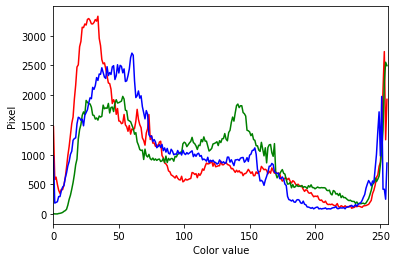

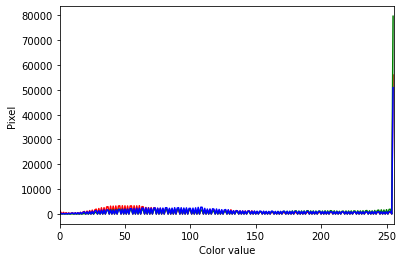

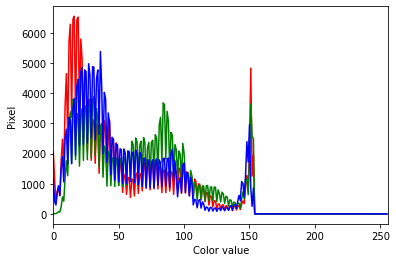

In [13]:
def show_chart(rgb_array):
    plt.xlim([0, 256])

    for channel_id, c in zip(range(3), 'rgb'):
        histogram, bin_edges = np.histogram(
            rgb_array[..., channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)

    plt.xlabel("Color value")
    plt.ylabel("Pixel")

    plt.show()

original = rgb_image.mul(255).numpy().transpose(1, 2, 0)
v1 = bright_rgb_image.mul(255).numpy().transpose(1, 2, 0)
v2 = dark_rgb_image.mul(255).numpy().transpose(1, 2, 0)

show_chart(original)
show_chart(v1)
show_chart(v2)